In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import backtrader as bt
import backtrader.talib as talib
import backtrader.feeds as btfeeds
import backtrader.feed
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
import itertools
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import time;
from datetime import timedelta 
import datetime
from sklearn import linear_model
import blackbox as bb
import math
from pprint import pprint
from backtrader import Indicator
import os

candle_freq = '4Hour'
coin_name = 'ETH'
datapath = os.path.abspath('..') + '/Data/GDAX/'
%tb

No traceback available to show.


In [2]:
candle_freq_to_seconds_map = {}
candle_freq_to_seconds_map['1Min'] = 60
candle_freq_to_seconds_map['3Min'] = 180
candle_freq_to_seconds_map['5Min'] = 300
candle_freq_to_seconds_map['15Min'] = 900
candle_freq_to_seconds_map['1Hour'] = 3600
candle_freq_to_seconds_map['4Hour'] = 14400
candle_freq_to_seconds_map['6Hour'] = 21600

### 1) First we do the preleminary in sample testing and make sure the results are same with the trading view results (without slippage and commissions)

In [3]:
class AcctStats(bt.Analyzer):
    """A simple analyzer that gets the gain in the value of the account; should be self-explanatory"""

    def __init__(self):
        self.start_val = self.strategy.broker.get_value()
        self.end_val = None

    def stop(self):
        self.end_val = self.strategy.broker.get_value()

    def get_analysis(self):
        return {"start": self.start_val, "end": self.end_val}

In [4]:
class ValueStats(bt.Analyzer):
    """A simple analyzer that gets the gain in the value of the account; should be self-explanatory"""
    val = []
    
    def __init__(self):
        self.val = []

    def next(self): 
        self.val.append(self.strategy.broker.get_value())
        

    def get_analysis(self):
        return self.val

In [5]:
class LinearRegression(Indicator):
    alias = ('LR',)
    
    
    lines = ('linear_regression','ma')
    params = (
        ('len', 300),
    )
    iter = 0 

    def changeLen(self,length):
        self.params.len = length
        
    def next(self):
        if (self.iter > self.params.len):
            raw_prices = self.data.get(size=self.params.len)
            prices = np.array(raw_prices).reshape(-1, 1)
            x_line = np.array([i for i in range(0, self.params.len)]).reshape(-1, 1)
            # Create linear regression object
            regr = linear_model.LinearRegression()
            # Train the model using the training sets
            regr.fit(x_line, prices)
            prediction = regr.predict(np.array([self.params.len]).reshape(-1, 1))
            self.lines.linear_regression[0] = prediction
        self.iter += 1

In [6]:
class MyStrategy(bt.Strategy):
    
    def_params = (
        ('linear_reg_length', 20),
    )
    
    params = (
        ('interval_params', [(999999999999999.0, def_params)]),
        ('printlog', False),
        ('usable_cash_ratio' , 0.5),
    )
    def log(self, txt, dt=None, tm=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            tm = tm or self.datas[0].datetime.time(0)
            print('%s, %s, %s' % (dt, tm, txt))
    
    def get_params_for_time(self):
        time_now_string = str(self.datas[0].datetime.date(0)).strip()
        time_now = time.mktime(time.strptime(time_now_string, "%Y-%m-%d"));
        if(self.sorted_params[self.interval_index][0] < time_now):
            self.interval_index += 1
            self.log('Params changed to : ' + str(self.sorted_params[self.interval_index][1]))
        return self.sorted_params[self.interval_index][1]
    
    def __init__(self):
        self.long = False
        self.dataclose = self.datas[0].close
        self.datalow = self.datas[0].low
        self.sorted_params = sorted(self.params.interval_params)
        self.cash_buffer = (self.broker.getvalue()*self.params.usable_cash_ratio)
        self.interval_index = 0 
        self.params_to_use = self.sorted_params[self.interval_index][1]
        self.LR_low_trend = LinearRegression(self.datalow, len=self.params_to_use['linear_reg_length'])
        self.LR_low_trend_to_use = self.LR_low_trend

    def next(self):
        self.params_to_use = self.get_params_for_time()
        self.LR_low_trend.changeLen(self.params_to_use['linear_reg_length'])
        if self.LR_low_trend_to_use < self.data.close and (not self.long):
            self.size_to_buy = int((self.broker.getvalue()-self.cash_buffer) /  self.dataclose[0])
            self.order = self.buy(exectype=bt.Order.Market, size=self.size_to_buy)
            self.long = True

        elif self.LR_low_trend_to_use > self.data.close and self.long:
            self.order = self.sell(exectype=bt.Order.Market, size=self.size_to_buy)
            self.long = False

In [7]:
def getData(start_timestamp, end_timestamp):
    path = datapath + str(coin_name) + '/' + str(candle_freq) + '.csv'
    frame = pd.read_csv(path)
    frame['time'] = pd.to_datetime(frame['time'], unit='s')
    frame = frame[(frame['time'] >= pd.to_datetime(start_timestamp, unit='s')) \
                  & (frame['time'] <= pd.to_datetime(end_timestamp, unit='s'))]
    frame = frame.sort_values(by=['time'])
    frame = frame.rename(columns={'time': 'datetime'})
    frame.set_index('datetime', inplace=True)

    
    return frame
    

In [8]:
def RunBackTest(coin_name,candle_freq,capital,start_timestamp,end_timestamp,params\
                                       ,shouldPlot=False, shouldPrint=False):

    frame_to_add = getData(start_timestamp, end_timestamp)
    pd_frame = bt.feeds.PandasData(dataname=frame_to_add)
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    # Add a strategy
    cerebro.addstrategy(MyStrategy ,interval_params = params['interval_params']\
                                                                       ,printlog = shouldPrint)
    # Set commision and slippage
    if('slippage' in params):  
        cerebro.broker.set_slippage_perc(perc=params['slippage'])
    if('commision' in params):
        cerebro.broker.setcommission(commission=params['commision'])

    # Analyzer
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='TradeAnalysis')
    cerebro.addanalyzer(btanalyzers.SharpeRatio,timeframe=bt.TimeFrame.Days,riskfreerate=0.0,\
                        _name='SharpeAnalysis')

    cerebro.addanalyzer(btanalyzers.DrawDown , _name='DrawDownAnalysis') 
        
    cerebro.addanalyzer(AcctStats, _name='ActualAnalysis')
    
    cerebro.addanalyzer(ValueStats, _name='ValueAnalysis')
                        
    cerebro.adddata(pd_frame)

    cerebro.broker.setcash(capital)

    starting_portfolio_value = cerebro.broker.getvalue()
    # Print out the starting conditions
    if(shouldPrint): print('Starting Portfolio Value: %.2f' % starting_portfolio_value)

    # Run over everything
    results = cerebro.run(runonce=False)
    
    ending_portfolio_value = cerebro.broker.getvalue()
    # Print out the final result
    if(shouldPrint): print('Final Portfolio Value: %.2f' % ending_portfolio_value)

    result = results[0]
    trade_anlaysis = result.analyzers.TradeAnalysis.get_analysis()
    sharpe_anlaysis = result.analyzers.SharpeAnalysis.get_analysis()
    #calmar_anlaysis = result.analyzers.CalmarAnalysis.get_analysis()
    drawdown_analysis = result.analyzers.DrawDownAnalysis.get_analysis()
    returns_anlaysis = result.analyzers.ActualAnalysis.get_analysis()
    value_anlaysis = result.analyzers.ValueAnalysis.get_analysis()

    try :
        total_pnl = returns_anlaysis['end'] - returns_anlaysis['start'] # ending_portfolio_value - starting_portfolio_value # trade_anlaysis['pnl']['gross']['total']
        num_won_trades = trade_anlaysis['won']['total']
        num_lost_trades = trade_anlaysis['lost']['total']
        
        sharperatio = sharpe_anlaysis['sharperatio']

        win_ratio = num_won_trades/(num_won_trades+num_lost_trades)
        used_capital = (capital*0.5)
        percentage_pnl = (total_pnl/ used_capital)*100
        max_drawdown = drawdown_analysis['max']['drawdown']
        calmarratio = percentage_pnl/math.sqrt((1+max_drawdown))
        if(shouldPlot): cerebro.plot(iplot=False,style='candle')#,style='line')
        return {'win_ratio':win_ratio, 'percentage_pnl':percentage_pnl,\
                'sharperatio': sharperatio, 'calmarratio' :calmarratio, 'trade_analysis':trade_anlaysis,\
               'value_anlaysis' : value_anlaysis}
    except:
        if(shouldPrint): print("Probably no trades were made")
        return {'win_ratio':1.0, 'percentage_pnl':0.0,'sharperatio' : 0.0, 'calmarratio' :-1.0\
                , 'trade_analysis':{}, 'value_anlaysis' : []}

In [9]:
%matplotlib notebook
tstart = time.mktime(time.strptime("20.01.2018 00:00:00", "%d.%m.%Y %H:%M:%S"));
tend = time.mktime(time.strptime("10.03.2019 11:05:02", "%d.%m.%Y %H:%M:%S"));


interval_params_one_time = time.mktime(time.strptime("01.02.2019 21:05:02", "%d.%m.%Y %H:%M:%S"));
interval_params_one = {}
interval_params_one['linear_reg_length'] = 300



interval_params_two_time = tend 
interval_params_two = {}
interval_params_two['linear_reg_length'] = 300

params={}
params['interval_params'] = [(interval_params_one_time , interval_params_one),\
                            (interval_params_two_time , interval_params_two)]


params['commision'] = 0
params['slippage'] = 0


max_lookback_buffer_param = max(interval_params_one.values())
needed_lookback_buffer_in_seconds = max_lookback_buffer_param*candle_freq_to_seconds_map[candle_freq]


start_date_with_buffer = tstart  - needed_lookback_buffer_in_seconds



limitedEntryTestResult = RunBackTest(coin_name,candle_freq,200000.0,start_date_with_buffer,tend,params,True,True)


print(limitedEntryTestResult['win_ratio'])
print('PnL: ' + str(limitedEntryTestResult['percentage_pnl']) + '%')
print(limitedEntryTestResult['sharperatio'])

Starting Portfolio Value: 200000.00
2019-02-02, 00:00:00, Params changed to : {'linear_reg_length': 300}
Final Portfolio Value: 210642.34
0.15625
PnL: 10.642339999999967%
0.015145557213765632


# Part 3 - Walk Forward Analysis

In [10]:
def get_params_to_optimize_ranges(optimization_params, tstart, tend):
    a = optimization_params['linear_reg_length']
    b = [tstart,tstart]
    c = [tend,tend]

    list_values = [ a,b,c]

    return list_values


In [11]:
def getOptimizedParamsBlackBox(optimized_params):
    params={}
    params['linear_reg_length'] = int(optimized_params[0])
    return params

In [12]:
def BlackBoxParallelWalkForwardAnalysis(start_date, end_date, optimization_period, out_of_sample_period\
                                        ,optimization_params, param_n, param_m, param_batch, OptFun\
                                        ,unanchored = True ):
    optimization_start_date = start_date - optimization_period
    optimization_end_date   = start_date
    
    testing_start_date      = start_date
    testing_end_date        = start_date + out_of_sample_period
    
    optimized_parameters = {}
    out_of_sample_result = {}
    
    while optimization_end_date < end_date:
        params_to_optimize_ranges = get_params_to_optimize_ranges(optimization_params\
                                                                  ,optimization_start_date\
                                                                  ,optimization_end_date)
        
        # Get the optimized params 
        optimization_start_date_key = str(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(optimization_start_date)))
        optimization_end_date_key = str(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(optimization_end_date)))
        optimization_key = optimization_start_date_key + "_" + optimization_end_date_key 
        print()
        print("*****************************************")
        print()
        print("Optimizing for :  ", optimization_start_date_key.split(" ")[0], " - ", \
              optimization_end_date_key.split(" ")[0], "  ...." )
        
        # Run optimization for in Sample Period.
        optimized_params = bb.search(f=OptFun,  # given function
                  box=params_to_optimize_ranges,  # range of values for each parameter (2D case)
                  n=param_n,  # number of function calls on initial stage (global search)
                  m=param_m,  # number of function calls on subsequent stage (local search)
                  batch=param_batch,  # number of calls that will be evaluated in parallel
                  resfile= os.getcwd() + '/output.csv') 
                # text file where results will be saved


        
        # Get the top 10 performing params for later analysis.
        optimized_parameters[optimization_key] = optimized_params[0:20]
        
        print("Optimization for start date : "\
              + str(optimization_start_date_key)\
              + " to end date : " +\
              str(optimization_end_date_key)\
              + " is completed.")
        print("testing dates for these optimization params are : ")
        print("testing start date: " + str(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(testing_start_date))))
        print("testing end date: " + str(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(testing_end_date))))
        
        if(unanchored):
            optimization_start_date += out_of_sample_period
            
        optimization_end_date   += out_of_sample_period
        
        testing_start_date      += out_of_sample_period
        testing_end_date        += out_of_sample_period
        
        
    return {'optimized_parameters' : optimized_parameters\
            ,'out_of_sample_result' : out_of_sample_result}

### BlackBox WalkForward

#### optimization_period = timedelta(days=30) out_of_sample_period = timedelta(days=6) 

In [13]:
def convertOptParamsToInputParams(paramsToOptimize):
    params={}
    params['linear_reg_length'] = int(paramsToOptimize[0])
    return params

In [14]:
def opt_fun(paramsToOptimize):
    
    tstart = paramsToOptimize[1]
    tend = paramsToOptimize[2]
    
    params=convertOptParamsToInputParams(paramsToOptimize)
    interval_params=convertOptParamsToInputParams(paramsToOptimize)
    
    params['interval_params'] = [(tend, interval_params)]
    params['commision'] = 0.0005
    params['slippage'] = 0.001
    
    testResult = RunBackTest(coin_name,candle_freq,200000.0,tstart,tend\
                                                                ,params,False,False)
    return -testResult['percentage_pnl']

In [15]:
def getEquityCurve(WalkForwardAnalysisResults, start_ind):
    
    equity_curve = []
    
    
    total_pnl = 100
    trade_date_keys = sorted(WalkForwardAnalysisResults.iterkeys())
    
    
    for ind , key in enumerate(trade_date_keys): 
        if(ind < start_ind) : continue
        this_result = WalkForwardAnalysisResults[key]
        this_pnl = (this_result['percentage_pnl'] +100)/100
        total_pnl = total_pnl*this_pnl
        equity_curve.append(total_pnl-100)
    return equity_curve


In [16]:
def getIntervalParamsFromOptimizedParams(optimized_params_list, out_of_sample_period, which_best):
    
    sorted_opt_params = sorted(optimized_params_list)
    
    interval_params = []
    out_of_sample_start_date_with_buffer = 0
    out_of_sample_start_date_to_log  = 0 
    end_date = 0
    
    for optimization_date_key in sorted_opt_params:
        optimized_params = optimized_params_list[optimization_date_key][which_best]
        optimization_end_date_key = optimization_date_key.split('_')[1]

        optimization_end_date = time.mktime(time.strptime(optimization_end_date_key, "%Y-%m-%d %H:%M:%S"));
        out_of_sample_start_date = optimization_end_date 
        out_of_sample_end_date = out_of_sample_start_date + out_of_sample_period
        optimized_params_for_this_run = getOptimizedParamsBlackBox(optimized_params)
        
        # This takes the first one and then never updates.
        if(out_of_sample_start_date_with_buffer == 0): 
            #We need a warm start for the indicators to get ready.
            max_lookback_buffer_param = max(optimized_params_for_this_run.values())
            needed_lookback_buffer_in_seconds = max_lookback_buffer_param*candle_freq_to_seconds_map[candle_freq]

            out_of_sample_start_date_with_buffer = out_of_sample_start_date  - needed_lookback_buffer_in_seconds
            out_of_sample_start_date_to_log = out_of_sample_start_date
        # This updates everytime and ends up with the last iteration.
        end_date = out_of_sample_end_date
        interval_params.append((out_of_sample_end_date, optimized_params_for_this_run ))
    return [interval_params, out_of_sample_start_date_with_buffer, out_of_sample_start_date_to_log, end_date]

In [17]:
def generateAlternateOutOfSampleResultsWithInterval(optimized_params_list, out_of_sample_period, top_best, shouldPlot):
    out_of_sample_results = []
    
    for i in range(top_best):
        out_of_sample_result = {}
        print("Doing " + str(i) + " th best params")
        [out_of_sample_interval_params_for_this_run,\
        out_of_sample_start_date_with_buffer,\
        out_of_sample_start_date,\
        out_of_sample_end_date] = getIntervalParamsFromOptimizedParams(optimized_params_list, out_of_sample_period,i)
        
        optimized_params_for_this_run = {}
        optimized_params_for_this_run['interval_params'] = out_of_sample_interval_params_for_this_run
        optimized_params_for_this_run['commision'] =  0.0005
        optimized_params_for_this_run['slippage']  = 0.001
             
        out_of_sample_end_date_key = str(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(out_of_sample_end_date)))

        out_of_sample_start_date_with_buffer_key =\
            str(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(out_of_sample_start_date_with_buffer)))
        out_of_sample_start_date_key =\
            str(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(out_of_sample_start_date)))
        
        out_of_sample_key = out_of_sample_start_date_with_buffer_key +\
                            "_" + out_of_sample_end_date_key


        # Run the out of sample Period with the optimized params
        OutOfSampleResults = RunBackTest(coin_name\
                                                                ,candle_freq\
                                                                ,200000.0\
                                                                ,out_of_sample_start_date_with_buffer\
                                                                ,out_of_sample_end_date\
                                                                ,optimized_params_for_this_run\
                                                                ,shouldPlot\
                                                                ,False)
        print("The interval end dates and params are: ")
        for param in out_of_sample_interval_params_for_this_run:
            print(str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(param[0]))) , param[1])
            
        print("Out of sample testing for start date " + out_of_sample_start_date_key + " and" +\
              " for the best : " + str(i) + "th param has finished!")
        print("Buffered Start Date was : " + out_of_sample_start_date_with_buffer_key)
        print()
        print('***********************************')
        print()
        
        out_of_sample_result[out_of_sample_key] = OutOfSampleResults
        out_of_sample_results.append(out_of_sample_result)
    return out_of_sample_results
    

## Walking Forward

In [ ]:
tstart = time.mktime(time.strptime("20.01.2018 00:00:00", "%d.%m.%Y %H:%M:%S"));
tend = time.mktime(time.strptime("10.03.2019 11:05:02", "%d.%m.%Y %H:%M:%S"));

optimization_period = timedelta(days=200).total_seconds()
out_of_sample_period = timedelta(days=90).total_seconds()

start_time = time.time()


optimization_params={}
optimization_params['linear_reg_length'] = [10,1000]
optimization_params['commision'] = 0.0005
optimization_params['slippage'] = 0.001

WalkForwardAnalysisResultsPNLAll_LastYear = BlackBoxParallelWalkForwardAnalysis(tstart\
                                                      ,tend\
                                                      ,optimization_period\
                                                      ,out_of_sample_period\
                                                      ,optimization_params\
                                                      ,100\
                                                      ,100\
                                                      ,4\
                                                      ,opt_fun)

end_time = time.time()

print(str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))))

print("Walk Forward Analysis Completed it took ")

diff = end_time - start_time
print(diff)
print("Seconds")


In [19]:
out_of_sample_period = timedelta(days=90).total_seconds()

interval_results_lastyear = generateAlternateOutOfSampleResultsWithInterval(WalkForwardAnalysisResultsPNLAll_LastYear['optimized_parameters']\
                                              ,out_of_sample_period,10, False)

Doing 0 th best params
The interval end dates and params are: 
2018-04-20 00:00:00 {'linear_reg_length': 10}
2018-07-19 00:00:00 {'linear_reg_length': 268}
2018-10-17 00:00:00 {'linear_reg_length': 446}
2019-01-15 00:00:00 {'linear_reg_length': 910}
2019-04-15 00:00:00 {'linear_reg_length': 431}
Out of sample testing for start date 2018-01-20 00:00:00 and for the best : 0th param has finished!
Buffered Start Date was : 2018-01-18 08:00:00

***********************************

Doing 1 th best params
The interval end dates and params are: 
2018-04-20 00:00:00 {'linear_reg_length': 10}
2018-07-19 00:00:00 {'linear_reg_length': 100}
2018-10-17 00:00:00 {'linear_reg_length': 460}
2019-01-15 00:00:00 {'linear_reg_length': 100}
2019-04-15 00:00:00 {'linear_reg_length': 460}
Out of sample testing for start date 2018-01-20 00:00:00 and for the best : 1th param has finished!
Buffered Start Date was : 2018-01-18 08:00:00

***********************************

Doing 2 th best params
The interval en

<IPython.core.display.Javascript object>


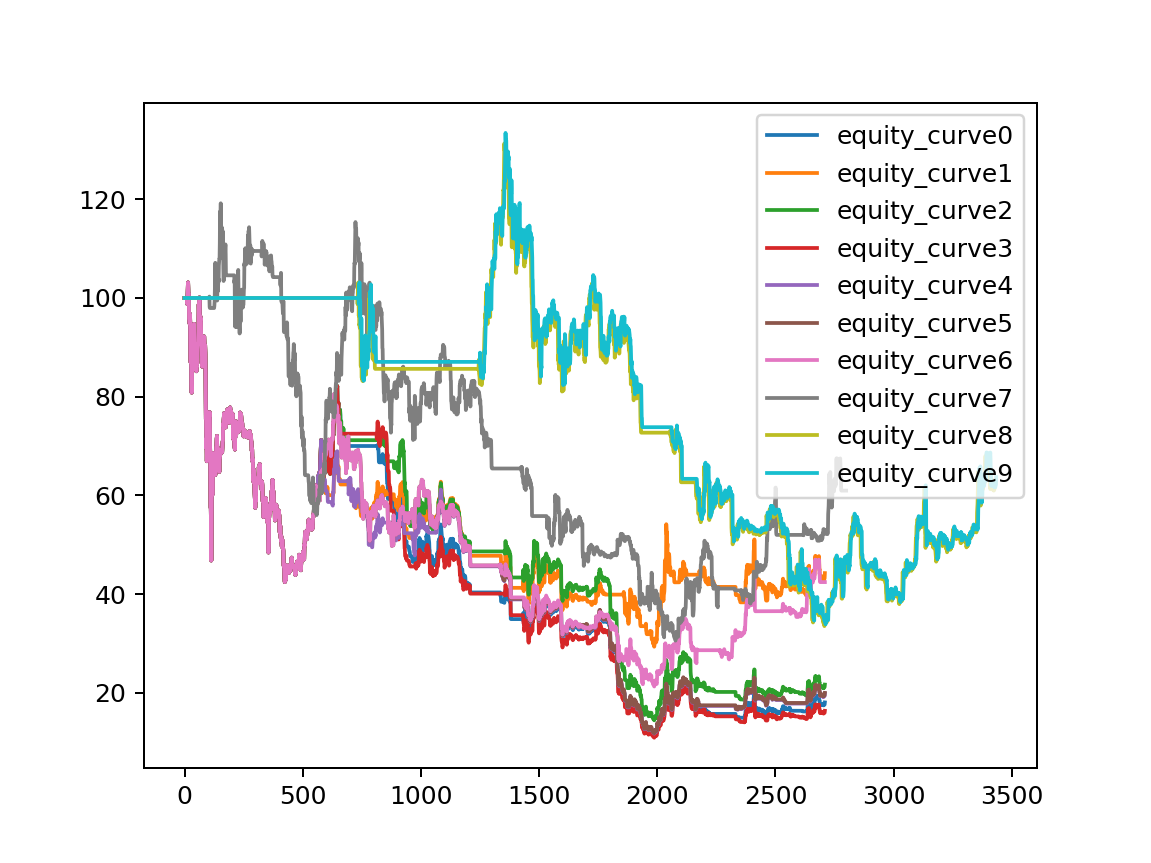

<IPython.core.display.Javascript object>


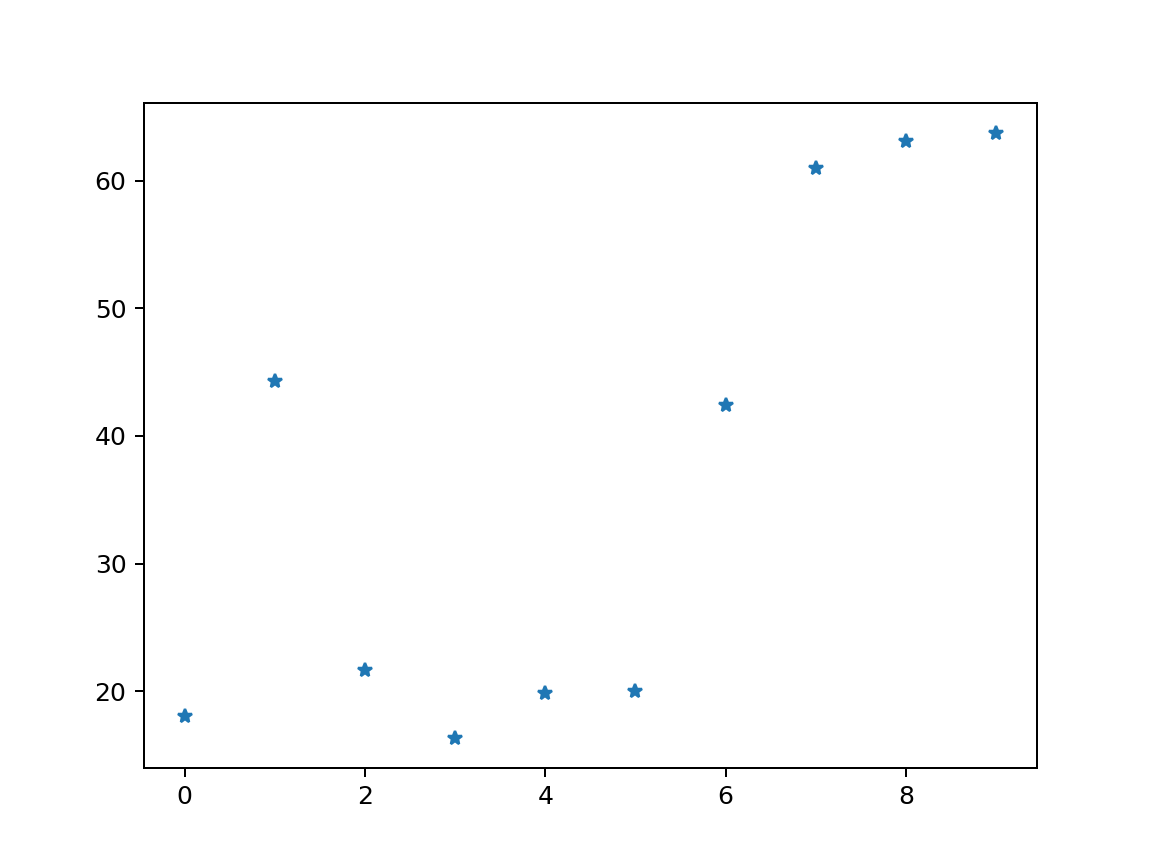

[18.084425733560668, 44.273578646650684, 21.69145148885064, 16.379456498715633, 19.866001929340708, 20.01400135587597, 42.45678297225098, 60.98481833883604, 63.06984872113111, 63.72602930218557]
average: 37.0546394987398
min: 16.379456498715633
max: 63.72602930218557


In [20]:
%matplotlib notebook

capital = 100000

value_to_plot = []
end_values = []

first_n = 10

for ind, result in enumerate(interval_results_lastyear):
    if(ind>first_n): break
    for key in result: # there is only 1 value
        value_to_plot = ((np.array(result[key]['value_anlaysis']) - capital) /capital)*100
        end_values.append(value_to_plot[-1])
        plt.plot(value_to_plot, label='equity_curve' + str(ind))
plt.legend()
plt.show()

plt.figure()
plt.plot(end_values,'*')
plt.show()

print(end_values)
print('average: ' + str(sum(end_values)/len(end_values)))
print('min: ' + str(min(end_values)))
print('max: ' + str(max(end_values)))